In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
import torch
from torch.utils.data import Subset

In [2]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)


Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [3]:
def subset_of_minst(minst_dataset, subset_size=500):
    """Create subset for given dataset"""
    digit_indices = {digit: [] for digit in range(10)}
    
    for idx, (_, target) in enumerate(minst_dataset):
        digit_indices[target].append(idx)
        
    selected_indexes = []
    for digit, indices in digit_indices.items():
        selected_indexes.extend(np.random.choice(indices, subset_size, replace=False))
    
    sub_minst_set = Subset(minst_dataset, selected_indexes)
    return sub_minst_set

In [41]:
INPUT_DIM = 32
BATCH_SIZE = 500
LATENT_DIM = 100

In [5]:


# Define transform to reshape the size of image
img_transforms = transforms.Compose([
    transforms.Resize((INPUT_DIM, INPUT_DIM)),
    transforms.ToTensor(),
])

# Download dataset
train_mnist = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=img_transforms)
test_mnist = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=img_transforms)

data_size = 1000
train_subset = subset_of_minst(train_mnist, data_size)

# Create a subset dataset from the selected indices

train_loader = torch.utils.data.DataLoader(train_subset, 
                                           batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_mnist, 
                                          batch_size=BATCH_SIZE, shuffle=False)

print(f'Training set {len(train_loader)} has instances')
print(f'test_loader set {len(test_loader)} has instances')

Training set 20 has instances
test_loader set 20 has instances


In [6]:
tr = iter(train_loader)
b, data = next(tr)
print(data.shape)

torch.Size([500])


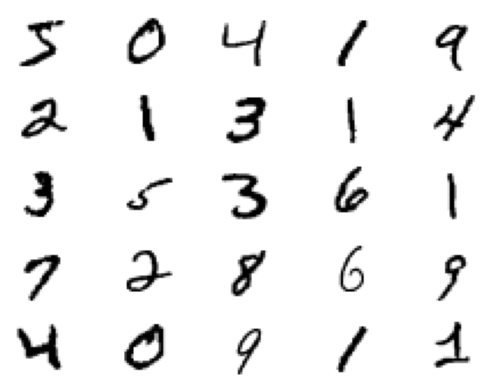

In [7]:
for i in range(25):
 # define subplot
 plt.subplot(5, 5, 1 + i)
 # turn off axis
 plt.axis('off')
 # plot raw pixel data
 plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [8]:
device = 'cpu'
# Check if MPS is supported and available
if torch.backends.mps.is_available():
    print("MPS is available on this device.")
    device = torch.device("mps")  # Use MPS device
else:
    print("MPS not available, using CPU instead.")
    device = torch.device("cpu")  # Fallback to CPU



MPS is available on this device.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Discriminator Net

In [57]:

class CompactDiscriminatorNet(nn.Module):
    
    def __init__(self):
        super(CompactDiscriminatorNet, self).__init__()
        
        self.cons_layers = nn.Sequential(
            nn.Conv2d(1, INPUT_DIM, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2304, 512),
            # nn.Linear(1600, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(512, 1),
            nn.Sigmoid() 
        )
        
    def forward(self, x):
        x = self.cons_layers(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
class SimpleDiscriminatorModel(nn.Module):
    
    def __init__(self):
        super(SimpleDiscriminatorModel, self).__init__()
        
        self.cons_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.4),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Flatten(),
            nn.Linear(4096, 1),
            nn.Sigmoid() 
        )
        
    def forward(self, x):
        x = self.cons_layers(x)
        return x
    


In [11]:
def generate_true_samples(train_dataset, batch_size=500):
    idx = torch.randint(low=0, high=len(train_dataset), size=(batch_size,))
    X = train_dataset.data[idx]
    X = X.unsqueeze(1)
    print(X.dtype)
    y = torch.ones((batch_size, 1), dtype=torch.float)
    return X, y
    

def generate_false_samples( batch_size=500):
    X = torch.rand(batch_size, 1, INPUT_DIM, INPUT_DIM) 
    y = torch.zeros((batch_size, 1)) 
    return X, y

In [44]:
true_samples = generate_true_samples(train_mnist, batch_size=BATCH_SIZE)
true_samples[0].shape

torch.uint8


torch.Size([500, 1, 28, 28])

In [53]:
import random

def train_discriminator(model, device, train_loader, iters=100):
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    loss_fn = F.binary_cross_entropy
    # loss_fn = nn.CrossEntropyLoss()
    datalist = []
    for b, data in train_loader:
        datalist.append(b)
        
    for it in range(iters):
        print(f'Iteration {it} / {iters}')
        
        train_data = random.choice(datalist) 
        # print(f'Random batch: {random_batch}')
        # train_data, label = random_batch
        print(f'Training data shape {train_data.shape}')
        # print(f'Label shape {label.shape}')
        # true_samples = generate_true_samples(train_mnist, batch_size=BATCH_SIZE)
        true_samples = (train_data, torch.ones((BATCH_SIZE, 1), dtype=torch.float))

        # # Iterate to the chosen batch index
        # for i, batch in enumerate(train_loader):
        #     if i == random_index:
        #         random_batch = batch
        #         break
        # true_samples = random_batch
        # print(true_samples.shape)
        _, true_acc = train_once(model, true_samples, device, loss_fn, optimizer)
        print(f'\ttrue sample acc: {true_acc}')
        false_samples = generate_false_samples(batch_size=BATCH_SIZE)
        # print(false_samples)
        _, false_acc = train_once(model, false_samples, device, loss_fn, optimizer)
        print(f'\tfalse sample acc: {false_acc}')
        

def train_once(model, samples, device, loss_fn, optimizer):
    inputs, labels = samples
    inputs = inputs.to(device)
    labels = labels.to(device)
    # clear gradient
    optimizer.zero_grad()
    outputs = model(inputs)
    # outputs = outputs.squeeze()
    # print(f'output: {outputs}')
    # print(outputs)
    # loss
    # print(labels.shape)
    loss = loss_fn(outputs, labels)
    loss.backward()
    # update parameters
    optimizer.step()
    predicted = outputs > 0.5  # Threshold logits at 0 for classification
    correct = (predicted == labels).float().sum()
    acc = correct / inputs.size(0)
    loss = loss.item()
    return loss, acc

In [58]:
d_model = SimpleDiscriminatorModel()
d_model.to(device)

train_discriminator(d_model, device, train_loader, iters=100)

Iteration 0 / 100
Training data shape torch.Size([500, 1, 32, 32])
	true sample acc: 0.3440000116825104
	false sample acc: 0.42800000309944153
Iteration 1 / 100
Training data shape torch.Size([500, 1, 32, 32])
	true sample acc: 0.3880000114440918
	false sample acc: 0.4399999976158142
Iteration 2 / 100
Training data shape torch.Size([500, 1, 32, 32])
	true sample acc: 0.4399999976158142
	false sample acc: 0.49799999594688416
Iteration 3 / 100
Training data shape torch.Size([500, 1, 32, 32])
	true sample acc: 0.37599998712539673
	false sample acc: 0.6399999856948853
Iteration 4 / 100
Training data shape torch.Size([500, 1, 32, 32])
	true sample acc: 0.3779999911785126
	false sample acc: 0.7900000214576721
Iteration 5 / 100
Training data shape torch.Size([500, 1, 32, 32])
	true sample acc: 0.3240000009536743
	false sample acc: 0.9200000166893005
Iteration 6 / 100
Training data shape torch.Size([500, 1, 32, 32])
	true sample acc: 0.25200000405311584
	false sample acc: 0.9739999771118164
It

# Generator Model

In [59]:
class CompactGeneratorNet(nn.Module):
    
    def __init__(self):
        super(CompactGeneratorNet, self).__init__()
        self.cons_layers = nn.Sequential(
            nn.Linear(LATENT_DIM, 128 * 8 * 8),
            nn.ReLU(inplace=True),
            
            nn.Unflatten(1, (128, 8, 8)),  # Corrected dimension ordering
            
            # upsample to 16 * 16
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # upsample to 32 * 32
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.cons_layers(x)
        return x
    
class SimpleGeneratorModel(nn.Module):
    
    def __init__(self):
        super(SimpleGeneratorModel, self).__init__()
        self.cons_layers = nn.Sequential(
            nn.Linear(LATENT_DIM, 128 * 8 * 8),
            nn.ReLU(inplace=True),
            
            nn.Unflatten(1, (128, 8, 8)),  # Corrected dimension ordering
            
            # upsample to 16 * 16
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # upsample to 32 * 32
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.cons_layers(x)
        return x

In [16]:
def generate_latent_point(n_samples, latent_dim):
    x = torch.randn(n_samples, latent_dim)
    
    return x

In [17]:
generate_latent_point(BATCH_SIZE, LATENT_DIM).shape

torch.Size([500, 100])

In [18]:
def generate_false_samples_v2(g_model, device, batch_size=500, latent_dim=100):
    X = generate_latent_point(batch_size, latent_dim)
    # print(f'Latent Points: {X.shape}')
    X = X.to(device)
    X = g_model(X)
    y = torch.zeros((batch_size, 1)) 
    # print(f'False sample: {X.shape}, y: {y.shape}')
    return X, y

In [19]:
g_model = CompactGeneratorNet()
g_model.to(device)

gen_ret = generate_false_samples_v2(g_model, device, BATCH_SIZE, LATENT_DIM)[0]
gen_ret.shape

torch.Size([500, 1, 32, 32])

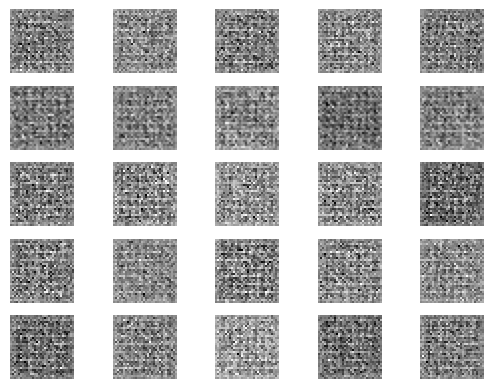

In [27]:
for i in range(25):
 # define subplot
 plt.subplot(5, 5, 1 + i)
 # turn off axis
 plt.axis('off')
 # plot raw pixel data
 plt.imshow(gen_ret[i, 0, :, :].detach().cpu().numpy(), cmap='gray_r')
plt.show()

# Train Generator Model

In [28]:
class GAN(nn.Module):
    
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        
        self.gan = nn.Sequential(
            generator,
            discriminator
        )
        
        
    def forward(self, x):
        return self.gan(x) 
        

In [29]:
gan_model = GAN(g_model, d_model)
gan_model.to(device)

GAN(
  (gan): Sequential(
    (0): CompactGeneratorNet(
      (cons_layers): Sequential(
        (0): Linear(in_features=32, out_features=8192, bias=True)
        (1): ReLU(inplace=True)
        (2): Unflatten(dim=1, unflattened_size=(128, 8, 8))
        (3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): Sigmoid()
      )
    )
    (1): CompactDiscriminatorNet(
      (cons_layers): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Dropout(p=0.2, inpla

In [39]:
def save_plot(samples, epoch, n = 10):
    # plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(samples[i, 0, :, :].detach().cpu().numpy().reshape(32, 32), cmap='gray_r')
	# save plot to file
	filename = './generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

def summarize_performance(epoch, g_model, d_model, test_loader, device, batch_size, latent_dim=100):
    g_model.eval()
    d_model.eval()

    avg_true_acc = 0.
    with torch.no_grad():
        for b, data in enumerate(test_loader):
            test_inputs, _ = data
            test_inputs = test_inputs.to(device)
            # test_labels = test_labels.to(device)
            
            test_labels = torch.ones((batch_size, 1), dtype=torch.float).to(device)

            test_outputs = d_model(test_inputs)

            # Accuracy
            predicted = test_outputs > 0.5  # Threshold logits at 0 for classification
            correct = (predicted == test_labels).float().sum()
    
            acc = correct / test_outputs.size(0)

            avg_true_acc += acc.cpu()
        avg_true_acc = avg_true_acc / len(test_loader)
    
    X_false, y_false = generate_false_samples_v2(g_model, device, batch_size, latent_dim)
    X_false = X_false.to(device)
    y_false = y_false.to(device)
    false_outputs = d_model(X_false) 
    
    false_predictd = (false_outputs > 0.5).to(device)
    false_correct = (false_predictd == y_false).float().sum()
    false_acc =  false_correct / len(X_false)
    
    print(f'\tEpoch[{epoch}] True acc: {avg_true_acc:.4f}, False acc: {false_acc:.4f}')
    
    save_plot(X_false, epoch)
    

def train_gan(g_model, d_model, gan_model, train_loader, device, epochs=100, batch_size=500, latent_dim=100):
    loss_fn = F.binary_cross_entropy
    optimizer_g = torch.optim.Adam(g_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = torch.optim.Adam(d_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
    print(device)
    for epoch in range(epochs):
        for b, batch_dataset in enumerate(train_loader):
            X_true, _ = batch_dataset
            X_true = X_true.to(device)
            
            y_true = torch.ones((batch_size, 1), dtype=torch.float)
            y_true = y_true.to(device)
            
            # Phase 1: Discriminating: Focusing on updating discriminator
            ## Generate false samples with a trained generator
            g_model.eval()
            d_model.train()
            
            X_false, y_false = generate_false_samples_v2(g_model, device, batch_size, latent_dim)
            y_false = y_false.to(device)
            X_false = X_false.to(device)
            
            # print(f'\tY shape, true: {y_true.shape}, false: {y_false.shape}')
            
            output_real = d_model(X_true)
           
            X, y = torch.vstack((X_true, X_false)), torch.vstack((y_true, y_false))
            
            ## Updating discriminator 
            d_loss, d_acc = train_once(d_model, (X, y), device, loss_fn, optimizer_d)
            
            # Phase 2: Polishing fake examples: Focusing on updating generator
            d_model.eval()
            g_model.train()
            X_gan = generate_latent_point(batch_size, latent_dim)
            y_gan = torch.ones((batch_size, 1))
            
            g_loss, g_acc = train_once(gan_model, (X_gan, y_gan), device, loss_fn, optimizer_g)
            
            print(f'Epoch[{epoch}], Batch[{b}] generator loss: {g_loss}, discriminator loss: {d_loss}')
        
        if (epoch + 1) % 10 == 0:
            # Plot performance every 5 epoch
            summarize_performance(epoch, g_model, d_model, test_loader, device, batch_size, latent_dim)
            
            
        # x_gan = generate_latent_point(batch_size, latent_dim) 
        # y_gan = torch.ones((batch_size, 1))
        # train_once(gan_model, (x_gan, y_gan), device, loss_fn, optimizer)

In [60]:
d_model = SimpleDiscriminatorModel()
d_model.to(device)

g_model = SimpleGeneratorModel()
g_model.to(device)

gan_model = GAN(g_model, d_model)
gan_model.to(device)

train_gan(g_model, d_model, gan_model, train_loader, device, epochs=40, batch_size=BATCH_SIZE, latent_dim=LATENT_DIM)

mps
Epoch[0], Batch[0] generator loss: 0.7699249386787415, discriminator loss: 0.6851555705070496
Epoch[0], Batch[1] generator loss: 0.7889807224273682, discriminator loss: 0.6752288937568665
Epoch[0], Batch[2] generator loss: 0.8105983138084412, discriminator loss: 0.6678388714790344
Epoch[0], Batch[3] generator loss: 0.8331387042999268, discriminator loss: 0.6555814743041992
Epoch[0], Batch[4] generator loss: 0.8563802242279053, discriminator loss: 0.648125946521759
Epoch[0], Batch[5] generator loss: 0.8762610554695129, discriminator loss: 0.6394484043121338
Epoch[0], Batch[6] generator loss: 0.8921819925308228, discriminator loss: 0.6315898895263672
Epoch[0], Batch[7] generator loss: 0.8980594873428345, discriminator loss: 0.6255025863647461
Epoch[0], Batch[8] generator loss: 0.8914616107940674, discriminator loss: 0.6192170977592468
Epoch[0], Batch[9] generator loss: 0.875278115272522, discriminator loss: 0.6165872812271118
Epoch[0], Batch[10] generator loss: 0.8466532230377197, di

KeyboardInterrupt: 

# Generate Images

In [37]:
n = 5
latent_points = generate_latent_point(n * n, 100)
latent_points = latent_points.to(device)
# generate images
g_rets = g_model(latent_points)
g_rets = g_rets.to(device)



In [ ]:
# plot images
for i in range(n * n):
	# define subplot
	plt.subplot(n, n, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(g_rets[i, 0, :, :].detach().cpu().numpy().reshape(32, 32), cmap='gray_r')